# Solve a non-linear inverse problem with MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Define some functions

### Non linear forward model

In [2]:
def forward(model):
    """
    Compute forward model
    """
    return model ** 2 + model

### Prior probability distribution

In [3]:
def prior(model, reference_model, error, sigma):
    """
    Compute the prior PDF as a Gaussian function
    """
    ss_prior = sum(((model - reference_model) / error) ** 2)
    # We need the square root of ss_prior, because the first argument of stats.norm.pdf
    # will be powered to 2 when computing the PDF (see docstring of stats.norm.pdf)
    ss_prior = np.sqrt(ss_prior)
    return stats.norm.pdf(ss_prior, loc=0, scale=sigma)

### Likelihood probability distribution

In [4]:
def likelihood(data, data_predicted, sigma):
    """
    Compute the likelihood PDF as a Gaussian function
    """
    ss = sum((data - data_predicted) ** 2)
    # We need the square root of ss, because the first argument of stats.norm.pdf
    # will be powered to 2 when computing the PDF (see docstring of stats.norm.pdf)
    ss = np.sqrt(ss)
    return stats.norm.pdf(ss, loc=0, scale=sigma)

## Generate data from a synthetic model

In [5]:
# Define synthetic model
model_synth = np.array([2.5, 4])

# Compute data generated by the synthetic model with white noise
error = 0.1
data = forward(model_synth) + error * np.random.randn(2)

## Define parameters for the inverse problem

In [6]:
iterations = int(5e4)  # number of iterations
temperatures = [1, 20]  # temperatures of the chains
probability_of_swap = 0.5  # the probability to attempt a swap

# Standard deviations
sigma_mcmc = [0.1, 2]  # standard deviation for the MCMC steps for each chain
sigma_prior = 10  # standard deviation for the prior (we choose it to be big)
sigma_likelihood = 1  # standard deviation for the likelihood (we choose it small)

# Reference and first proposal models
reference_model = [0, 0]  # reference model used on the prior
start_model = np.array([-5, -5])  # model from which the MCMC will start

## Initialize arrays and chains

In [7]:
n_chains = len(temperatures)  # get number of chains
models = np.zeros((n_chains, 2))  # array for models on each chain
probability = np.zeros(n_chains)  # probability for the model on each chain
sampled_points = np.empty((n_chains, iterations, 2))

for chain in range(n_chains):
    # Proposal
    models[chain, :] = start_model + sigma_mcmc[chain] * np.random.randn(2)
    # Compute probability of the proposed models on each chain
    probability[chain] = likelihood(
        data, forward(models[chain]), sigma_likelihood
    ) * prior(models[chain], reference_model, error, sigma_prior)

## Perform Parallel Tempering with two chains

In [8]:
for i in range(iterations):
    
    # Decide whether to swap chains or not
    if probability_of_swap > np.random.rand():
        # Compute alpha
        alpha = min(
            1,
            (probability[1] / probability[0]) ** (1 / temperatures[0])
            * (probability[0] / probability[1]) ** (1 / temperatures[1]),
        )
        # Decide if we should swap
        if alpha > np.random.rand():
            models[0, :], models[1, :] = models[1, :], models[0, :]
            probability[0], probability[1] = probability[1], probability[0]

    # Perform MCMC
    for chain in range(n_chains):
        model_trial = models[chain, :] + sigma_mcmc[chain] * np.random.randn(2)
        # Lets compute the posterior PDF
        probability_trial = likelihood(
            data, forward(model_trial), sigma_likelihood
        ) * prior(model_trial, reference_model, error, sigma_prior)
        # Compute the acceptance probability
        acceptance = min(
            1, (probability_trial / probability[chain]) ** (1 / temperatures[chain])
        )
        if acceptance > np.random.rand():
            models[chain, :] = model_trial
            probability[chain] = probability_trial
        # Add sampled points to array
        sampled_points[chain, i, :] = models[chain, :]

## Plot results

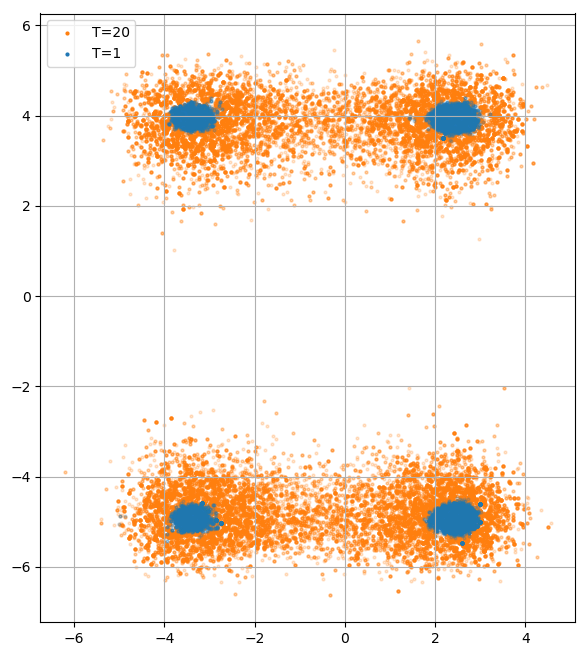

In [9]:
colors = ["C0", "C1"]
fig, ax = plt.subplots(figsize=(6.66, 6.66), dpi=100)

for chain in range(n_chains)[::-1]:
    ax.scatter(
        sampled_points[chain, :, 0],
        sampled_points[chain, :, 1],
        s=4,
        alpha=0.2,
        color=colors[chain],
        label="T={}".format(temperatures[chain]),
    )
ax.set_aspect("equal")
ax.grid()
legend = ax.legend()
for symbol in legend.legendHandles:
    symbol.set_alpha(1)  # make legend symbol non-transparent
fig.tight_layout()
plt.show()

### Plot histograms

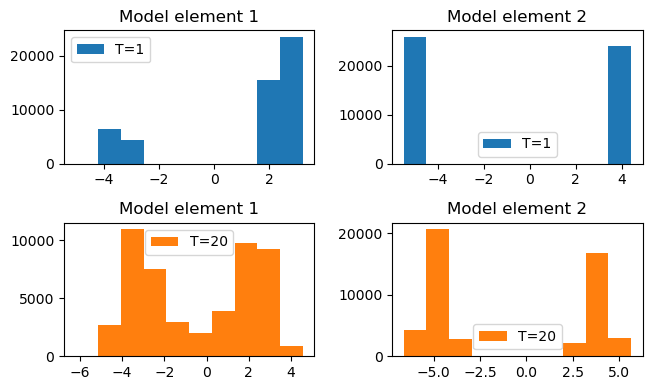

In [13]:
fig, axes = plt.subplots(nrows=n_chains, ncols=2, figsize=(6.66, 4), dpi=100)
for chain in range(n_chains):
    ax_row = axes[chain, :]
    for coordinate in range(2):
        ax_row[coordinate].hist(
            sampled_points[chain, :, coordinate],
            color=colors[chain],
            label="T={}".format(temperatures[chain]),
        )
        ax_row[coordinate].legend()
        ax_row[coordinate].set_title("Model element {}".format(coordinate + 1))
fig.tight_layout()
plt.show()

### Trace plots

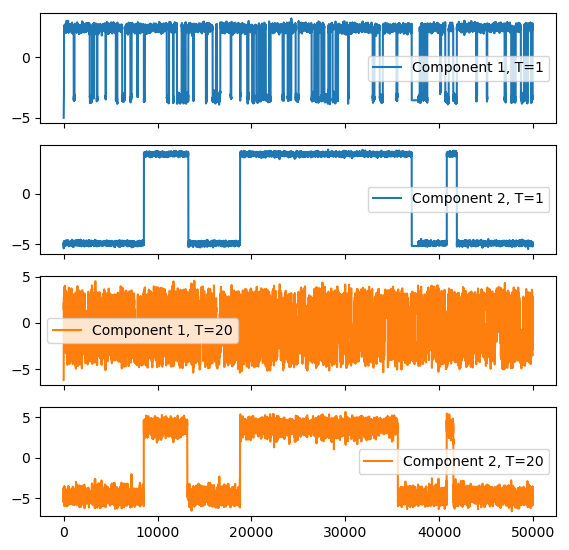

In [11]:
fig, axes = plt.subplots(
    nrows=2 * n_chains,
    ncols=1,
    sharex=True,
    figsize=(6.66, 6.66),
    dpi=100
)

i = 0
for chain in range(n_chains):
    for coordinate in range(2):
        axes[i].plot(
            sampled_points[chain, :, coordinate],
            color=colors[chain],
            label="Component {}, T={}".format(coordinate + 1, temperatures[chain]),
        )
        axes[i].legend()
        i += 1
plt.show()